## Курсовой проект для курса "Python для Data Science"

Материалы к проекту (файлы): train.csv test.csv

Задание: Используя данные из train.csv, построить модель для предсказания цен на недвижимость (квартиры). С помощью полученной модели предсказать цены для квартир из файла test.csv.

Целевая переменная: Price

Основная метрика: R2 - коэффициент детерминации (sklearn.metrics.r2_score)

In [264]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression

import random

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

### Загрузка данных

#### Описание датасета

Id - идентификационный номер квартиры

DistrictId - идентификационный номер района

Rooms - количество комнат

Square - площадь

LifeSquare - жилая площадь

KitchenSquare - площадь кухни

Floor - этаж

HouseFloor - количество этажей в доме

HouseYear - год постройки дома

Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности

Social_1, Social_2, Social_3 - социальные показатели местности

Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья

Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров

Price - цена квартиры

In [265]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
print("Data is loaded!")

Data is loaded!


In [266]:
print(f"Train:\t{train_df.shape[0]}\t sales and {train_df.shape[1]} features")
print(f'Test:\t{test_df.shape[0]}\t sales and {test_df.shape[1]} features')

Train:	10000	 sales and 20 features
Test:	5000	 sales and 19 features


In [267]:
train_df = train_df.set_index('Id')
test_df = test_df.set_index('Id')

In [268]:
train_df.head() # Первые 5 строк данных тренировочного датасета.

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [269]:
test_df.head() # Первые 5 строк данных тестового датасета.

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


## Обзор данных

In [270]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  int64  
 1   Rooms          10000 non-null  float64
 2   Square         10000 non-null  float64
 3   LifeSquare     7887 non-null   float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor          10000 non-null  int64  
 6   HouseFloor     10000 non-null  float64
 7   HouseYear      10000 non-null  int64  
 8   Ecology_1      10000 non-null  float64
 9   Ecology_2      10000 non-null  object 
 10  Ecology_3      10000 non-null  object 
 11  Social_1       10000 non-null  int64  
 12  Social_2       10000 non-null  int64  
 13  Social_3       10000 non-null  int64  
 14  Healthcare_1   5202 non-null   float64
 15  Helthcare_2    10000 non-null  int64  
 16  Shops_1        10000 non-null  int64  
 17  Shops_2        10000 non-null  object 
 18  Pri

In [271]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,2.090000e+02
Rooms,10000.0,1.890500,0.839512,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315775,21.058732,1.136859,41.774881,52.513310,65.900625,6.410652e+02
LifeSquare,7887.0,37.199645,86.241209,0.370619,22.769832,32.781260,45.128803,7.480592e+03
KitchenSquare,10000.0,6.273300,28.560917,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.775974,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218671e-01
Social_1,10000.0,24.687000,17.532614,0.000000,6.000000,25.000000,36.000000,7.400000e+01


In [272]:
# Приведение типов
train_df['DistrictId'] = train_df['DistrictId'].astype(str)
train_df['Rooms'] = train_df['Rooms'].astype(int)
train_df['HouseFloor'] = train_df['HouseFloor'].astype(int)

In [273]:
#Аналогино с тестовыми данными
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 725 to 12504
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     5000 non-null   int64  
 1   Rooms          5000 non-null   float64
 2   Square         5000 non-null   float64
 3   LifeSquare     3959 non-null   float64
 4   KitchenSquare  5000 non-null   float64
 5   Floor          5000 non-null   int64  
 6   HouseFloor     5000 non-null   float64
 7   HouseYear      5000 non-null   int64  
 8   Ecology_1      5000 non-null   float64
 9   Ecology_2      5000 non-null   object 
 10  Ecology_3      5000 non-null   object 
 11  Social_1       5000 non-null   int64  
 12  Social_2       5000 non-null   int64  
 13  Social_3       5000 non-null   int64  
 14  Healthcare_1   2623 non-null   float64
 15  Helthcare_2    5000 non-null   int64  
 16  Shops_1        5000 non-null   int64  
 17  Shops_2        5000 non-null   object 
dtypes: fl

In [274]:
test_df.describe().T

,count,mean,std,min,25%,50%,75%,max
DistrictId,5000.0,51.279200,44.179466,0.000000,21.000000,37.000000,77.000000,212.000000
Rooms,5000.0,1.910000,0.838594,0.000000,1.000000,2.000000,2.000000,17.000000
Square,5000.0,56.449500,19.092787,1.378543,41.906231,52.921340,66.285129,223.453689
LifeSquare,3959.0,36.158810,17.825287,0.333490,23.092026,32.925087,45.174091,303.071094
KitchenSquare,5000.0,5.976800,9.950018,0.000000,1.000000,6.000000,9.000000,620.000000
Floor,5000.0,8.632000,5.483228,1.000000,4.000000,7.000000,12.000000,78.000000
HouseFloor,5000.0,12.601000,6.789213,0.000000,9.000000,12.000000,17.000000,99.000000
HouseYear,5000.0,1984.392600,18.573149,1908.000000,1973.000000,1977.000000,2000.000000,2020.000000
Ecology_1,5000.0,0.119874,0.120070,0.000000,0.019509,0.072158,0.195781,0.521867
Social_1,5000.0,24.933800,17.532202,0.000000,6.000000,25.000000,36.000000,74.000000


In [275]:
#Приведение типов
test_df['DistrictId'] = test_df['DistrictId'].astype(str)
test_df['Rooms'] = test_df['Rooms'].astype(int)
test_df['HouseFloor'] = test_df['HouseFloor'].astype(int)

#### Целевая переменная

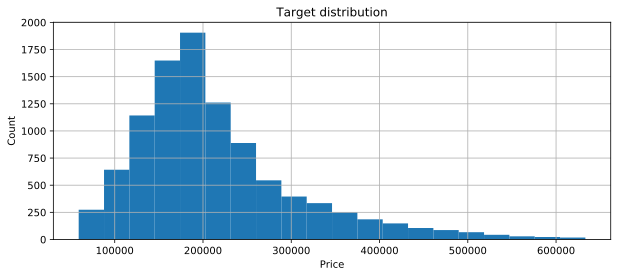

In [276]:
plt.figure(figsize = (10, 4))

train_df['Price'].hist(bins=20)
plt.ylabel('Count')
plt.xlabel('Price')
plt.title('Target distribution')
plt.show()

#### Категориальные переменные

In [277]:
train_df.describe(include=['O']).T

,count,unique,top,freq
DistrictId,10000,205,27,851
Ecology_2,10000,2,B,9903
Ecology_3,10000,2,B,9725
Shops_2,10000,2,B,9175


In [278]:
test_df.describe(include=['O']).T

,count,unique,top,freq
DistrictId,5000,201,27,391
Ecology_2,5000,2,B,4952
Ecology_3,5000,2,B,4851
Shops_2,5000,2,B,4588


#### Количественные переменные

In [279]:
# 15 признаков (1 целевой 'Price')
train_df.describe(include=[np.number]).T

,count,mean,std,min,25%,50%,75%,max
Rooms,10000.0,1.890500,0.839512,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315775,21.058732,1.136859,41.774881,52.513310,65.900625,6.410652e+02
LifeSquare,7887.0,37.199645,86.241209,0.370619,22.769832,32.781260,45.128803,7.480592e+03
KitchenSquare,10000.0,6.273300,28.560917,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.775974,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218671e-01
Social_1,10000.0,24.687000,17.532614,0.000000,6.000000,25.000000,36.000000,7.400000e+01
Social_2,10000.0,5352.157400,4006.799803,168.000000,1564.000000,5285.000000,7227.000000,1.908300e+04


In [280]:
# 14 признаков
test_df.describe(include=[np.number]).T

,count,mean,std,min,25%,50%,75%,max
Rooms,5000.0,1.910000,0.838594,0.000000,1.000000,2.000000,2.000000,17.000000
Square,5000.0,56.449500,19.092787,1.378543,41.906231,52.921340,66.285129,223.453689
LifeSquare,3959.0,36.158810,17.825287,0.333490,23.092026,32.925087,45.174091,303.071094
KitchenSquare,5000.0,5.976800,9.950018,0.000000,1.000000,6.000000,9.000000,620.000000
Floor,5000.0,8.632000,5.483228,1.000000,4.000000,7.000000,12.000000,78.000000
HouseFloor,5000.0,12.601000,6.789213,0.000000,9.000000,12.000000,17.000000,99.000000
HouseYear,5000.0,1984.392600,18.573149,1908.000000,1973.000000,1977.000000,2000.000000,2020.000000
Ecology_1,5000.0,0.119874,0.120070,0.000000,0.019509,0.072158,0.195781,0.521867
Social_1,5000.0,24.933800,17.532202,0.000000,6.000000,25.000000,36.000000,74.000000
Social_2,5000.0,5406.900000,4026.614773,168.000000,1564.000000,5285.000000,7287.000000,19083.000000


#### Обработка выбросов

##### Rooms
Изменяем данные о комнатах с большим количеством комнат и маленькой площадью.¶
Количество комнат заменяем в прямой зависимости от площади.

In [281]:
train_df['Rooms'].value_counts()

2     3880
1     3705
3     2235
4      150
5       18
0        8
10       2
6        1
19       1
Name: Rooms, dtype: int64

In [282]:
# Квартиры без комнат.
train_df.loc[train_df['Rooms'] < 1, : ]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
12638,27,0,138.427694,136.215499,0.0,4,3,2016,0.075424,B,B,11,3097,0,NaN,0,0,B,268394.744389
7917,27,0,212.932361,211.231125,0.0,2,3,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887
7317,27,0,41.790881,NaN,0.0,13,0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,98129.976788
770,28,0,49.483501,NaN,0.0,16,0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463
456,6,0,81.491446,NaN,0.0,4,0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.799112
3224,27,0,2.377248,0.873147,0.0,1,0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.941798
3159,88,0,38.697117,19.345131,9.0,9,16,1982,0.127376,B,B,43,8429,3,NaN,3,9,B,158998.110646
9443,27,0,87.762616,85.125471,0.0,5,15,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,219281.918007


In [283]:
# Квартиры с аномальным количеством комнат, не совпадающие с площадью квартиры.
train_df.loc[train_df['Rooms'] > 6, :]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
5927,57,10,59.056975,36.223072,10.0,22,22,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,317265.323792
8491,1,19,42.006046,21.779288,7.0,17,17,2014,0.007122,B,B,1,264,0,NaN,0,1,B,78364.616704
14865,9,10,60.871266,38.420681,10.0,3,2,1994,0.161532,B,B,25,5648,1,30.0,2,4,B,172329.270863


In [284]:
def clean_rooms(df, source_df):
    df.loc[(df['Rooms'] < 1) & (df['Square'] > 100), 'Rooms'] = source_df['Rooms'].quantile(.90)
    df.loc[(df['Rooms'] < 1) & (df['Square'] < 100), 'Rooms'] = source_df['Rooms'].median()
    df.loc[(df['Rooms'] > 6) & (df['Square'] < 100), 'Rooms'] = source_df['Rooms'].median()
    return df

In [285]:
clean_rooms(train_df, train_df)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
15053,41,3.0,65.683640,40.049543,8.0,7,9,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
4765,53,2.0,44.947953,29.197612,0.0,8,12,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
5809,58,2.0,53.352981,52.731512,9.0,8,17,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
10783,99,1.0,39.649192,23.776169,7.0,11,12,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,32,2.0,50.401785,30.476203,5.0,6,5,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
6159,18,1.0,41.521546,20.539216,9.0,13,13,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
5123,27,1.0,47.939008,NaN,1.0,12,16,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370


In [286]:
train_df['Rooms'].value_counts()

2.0    3889
1.0    3705
3.0    2237
4.0     150
5.0      18
6.0       1
Name: Rooms, dtype: int64

In [287]:
#Аналогично с тестовыми данными
test_df['Rooms'].value_counts()

2     2030
1     1769
3     1099
4       90
5        7
6        2
0        2
17       1
Name: Rooms, dtype: int64

In [288]:
clean_rooms(test_df, train_df)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
725,58,2.0,49.882643,33.432782,6.0,6,14,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
15856,74,2.0,69.263183,NaN,1.0,6,1,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
5480,190,1.0,13.597819,15.948246,12.0,2,5,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
15664,47,2.0,73.046609,51.940842,9.0,22,22,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
14275,27,1.0,47.527111,43.387569,1.0,17,17,2017,0.072158,B,B,2,629,1,NaN,0,0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8180,11,3.0,67.133911,50.809797,6.0,5,9,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4695,1,1.0,40.198472,21.807061,10.0,12,17,2017,0.007122,B,B,1,264,0,NaN,0,1,B
5783,12,3.0,77.842178,48.282625,9.0,23,22,1989,0.090799,B,B,74,19083,2,NaN,5,15,B


#### Square
Площадь квартиры скорее всего не менее 15 кв.м., так как включает кухню и жилую площадь.

In [289]:
train_df.loc[train_df['Square'] < 15, :]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
1748,88,2.0,5.497061,67.628717,1.0,24,22,1977,0.127376,B,B,43,8429,3,NaN,3,9,B,412511.088764
11526,27,1.0,4.633498,1.969969,1.0,18,1,1977,0.011654,B,B,4,915,0,NaN,0,0,B,107604.269441
10202,6,1.0,2.596351,4.604943,1.0,3,25,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,137597.601458
10527,27,1.0,4.380726,40.805837,1.0,10,17,2013,0.211401,B,B,9,1892,0,NaN,0,1,B,97560.720383
9487,5,1.0,5.129222,5.549458,1.0,1,1,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,369472.403061
12676,81,3.0,13.784865,15.988889,7.0,4,5,1960,0.319809,B,B,25,4756,16,2857.0,5,8,B,78388.806186
3224,27,2.0,2.377248,0.873147,0.0,1,0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.941798
4504,27,3.0,4.390331,5.610772,1.0,8,19,2016,0.211401,B,B,9,1892,0,NaN,0,1,B,161379.067034
14786,1,1.0,1.136859,4.525736,1.0,3,1,1977,0.007122,B,B,1,264,0,NaN,0,1,B,181434.825589


In [290]:
def clean_square(df, source_df):
    df.loc[(df['Rooms'] == 1) & (df['Square'] < 15), 'Square'] = source_df['Square'].quantile(.25)
    df.loc[(df['Rooms'] == 2) & (df['Square'] < 15), 'Square'] = source_df['Square'].median()
    df.loc[(df['Rooms'] >= 3) & (df['Square'] < 15), 'Square'] = source_df['Square'].quantile(.75)
    return df

In [291]:
clean_square(train_df, train_df)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
15053,41,3.0,65.683640,40.049543,8.0,7,9,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
4765,53,2.0,44.947953,29.197612,0.0,8,12,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
5809,58,2.0,53.352981,52.731512,9.0,8,17,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
10783,99,1.0,39.649192,23.776169,7.0,11,12,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,32,2.0,50.401785,30.476203,5.0,6,5,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
6159,18,1.0,41.521546,20.539216,9.0,13,13,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
5123,27,1.0,47.939008,NaN,1.0,12,16,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370


In [292]:
train_df.Square.describe()

count    10000.000000
mean        56.373648
std         20.980015
min         16.117154
25%         41.783674
50%         52.535436
75%         65.901523
max        641.065193
Name: Square, dtype: float64

In [293]:
clean_square(test_df, train_df)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
725,58,2.0,49.882643,33.432782,6.0,6,14,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
15856,74,2.0,69.263183,NaN,1.0,6,1,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
5480,190,1.0,41.783674,15.948246,12.0,2,5,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
15664,47,2.0,73.046609,51.940842,9.0,22,22,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
14275,27,1.0,47.527111,43.387569,1.0,17,17,2017,0.072158,B,B,2,629,1,NaN,0,0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8180,11,3.0,67.133911,50.809797,6.0,5,9,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4695,1,1.0,40.198472,21.807061,10.0,12,17,2017,0.007122,B,B,1,264,0,NaN,0,1,B
5783,12,3.0,77.842178,48.282625,9.0,23,22,1989,0.090799,B,B,74,19083,2,NaN,5,15,B


In [294]:
test_df.Square.describe()

count    5000.000000
mean       56.524440
std        18.964905
min        16.319015
25%        41.912403
50%        52.921340
75%        66.285129
max       223.453689
Name: Square, dtype: float64

#### KitchenSquare

In [295]:
train_df.KitchenSquare.describe()

count    10000.000000
mean         6.273300
std         28.560917
min          0.000000
25%          1.000000
50%          6.000000
75%          9.000000
max       2014.000000
Name: KitchenSquare, dtype: float64

In [296]:
# Кухни, площадь которых больше половины площади квартиры. 
# При такой величине кухни жилая площадь значительно уменьшается или преобретает отрицательные значения.
# Несоразмерность площадей.
train_df.loc[train_df['KitchenSquare'] > 0.5*train_df['Square'], : ]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
16395,2,3.0,79.722243,44.731219,72.0,12,16,1987,0.130618,B,B,39,10418,9,900.0,1,9,B,370148.625285
1315,6,1.0,48.128114,45.023531,48.0,21,1,2013,0.243205,B,B,5,1564,0,540.0,0,0,B,146950.912410
14656,62,1.0,47.100719,46.447960,2014.0,4,1,2014,0.072158,B,B,2,629,1,NaN,0,0,A,108337.484207
9690,27,1.0,40.081042,37.834964,37.0,18,19,2019,0.211401,B,B,9,1892,0,NaN,0,1,B,93218.650461
2371,27,2.0,68.841073,64.234956,66.0,4,2,2014,0.017647,B,B,2,469,0,NaN,0,0,B,189244.249909
12507,54,2.0,79.810535,79.578961,78.0,10,15,2014,0.006076,B,B,30,5285,0,645.0,6,6,B,438708.707579
4265,161,2.0,53.216778,32.644859,53.0,7,17,1994,0.000699,B,B,14,3369,24,4129.0,0,3,B,261125.669724
12390,72,3.0,97.490674,99.323558,96.0,22,25,2019,0.210473,B,B,11,2398,2,1994.0,3,0,B,445074.956552
7441,62,3.0,114.734473,112.589083,112.0,3,3,2015,0.072158,B,B,2,629,1,NaN,0,0,A,315245.521059


In [297]:
kitchen_square = train_df.loc[train_df['KitchenSquare'] > 0.5*train_df['Square'], 'Square']

In [298]:
train_df.loc[train_df['KitchenSquare'] > (0.5*train_df['Square']), 
             'KitchenSquare'] = 0.25*kitchen_square

In [299]:
# Кухни меньше 3 кв.м
train_df.loc[train_df['KitchenSquare'] < 3, : ]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
4765,53,2.0,44.947953,29.197612,0.0,8,12,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
11993,74,2.0,80.312926,NaN,0.0,14,0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,221244.156664
5172,1,2.0,64.511437,NaN,1.0,9,17,1977,0.007122,B,B,1,264,0,NaN,0,1,B,229102.795999
6452,13,2.0,54.522805,31.759753,1.0,8,12,1999,0.090799,B,B,74,19083,2,NaN,5,15,B,229220.372609
10953,27,1.0,53.769097,52.408027,1.0,5,4,1977,0.072158,B,B,2,629,1,NaN,0,0,A,140647.565937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16159,27,1.0,38.968338,NaN,1.0,10,1,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,95529.569405
2996,1,2.0,64.994245,NaN,1.0,9,22,1977,0.007122,B,B,1,264,0,NaN,0,1,B,200332.511658
15623,23,2.0,55.620092,NaN,0.0,2,4,1977,0.034656,B,B,0,168,0,NaN,0,0,B,115797.553006


In [300]:
def clean_kitchensquare(df, source_df):
    df.loc[(df['KitchenSquare'] < 3) & (df['Rooms'] == 1), 'KitchenSquare'] = source_df['KitchenSquare'].median()
    df.loc[(df['KitchenSquare'] < 3) & (df['Rooms'] == 2), 'KitchenSquare'] = source_df['KitchenSquare'].quantile(.75)
    df.loc[(df['KitchenSquare'] < 3) & (df['Rooms'] >= 3), 'KitchenSquare'] = source_df['KitchenSquare'].quantile(.99)
    return df

In [301]:
clean_kitchensquare(train_df, train_df)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
15053,41,3.0,65.683640,40.049543,8.0,7,9,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
4765,53,2.0,44.947953,29.197612,9.0,8,12,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
5809,58,2.0,53.352981,52.731512,9.0,8,17,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
10783,99,1.0,39.649192,23.776169,7.0,11,12,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,32,2.0,50.401785,30.476203,5.0,6,5,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
6159,18,1.0,41.521546,20.539216,9.0,13,13,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
5123,27,1.0,47.939008,NaN,6.0,12,16,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370


In [302]:
train_df.KitchenSquare.describe()

count    10000.000000
mean         8.303322
std          2.906268
min          3.000000
25%          6.000000
50%          8.000000
75%          9.000000
max         43.000000
Name: KitchenSquare, dtype: float64

In [303]:
#Аналогично обрабатываем кухни тестовых данных
test_df.KitchenSquare.describe()

count    5000.000000
mean        5.976800
std         9.950018
min         0.000000
25%         1.000000
50%         6.000000
75%         9.000000
max       620.000000
Name: KitchenSquare, dtype: float64

In [304]:
# Кухни, площадь которых больше половины площади квартиры. 
# При такой величине кухни жилая площадь значительно уменьшается или преобретает отрицательные значения.
# Несоразмерность площадей.
test_df.loc[test_df['KitchenSquare'] > 0.5*test_df['Square'], : ]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
5428,27,2.0,62.326044,NaN,61.0,12,17,1977,0.072158,B,B,2,629,1,NaN,0,0,A
5260,73,3.0,69.358242,51.247581,65.0,6,6,1931,0.042032,B,B,37,6856,84,1940.0,2,5,B
3341,62,3.0,112.114019,112.247841,112.0,3,3,2017,0.072158,B,B,2,629,1,NaN,0,0,A
14594,11,2.0,42.795304,24.223770,620.0,11,14,1972,0.038693,B,B,28,6533,1,1015.0,2,5,B
10662,29,1.0,25.956829,17.251768,33.0,5,5,1973,0.069660,B,B,31,6119,4,NaN,1,2,B
4483,62,1.0,41.951462,45.672140,41.0,13,17,2018,0.072158,B,B,2,629,1,NaN,0,0,A
12612,27,2.0,60.988496,33.646726,60.0,5,17,2013,0.072158,B,B,2,629,1,NaN,0,0,A
3194,29,2.0,43.926987,31.028707,44.0,6,5,1964,0.086885,B,B,10,2277,2,1547.0,0,0,B
6568,78,1.0,46.827201,40.227011,40.0,5,32,2007,0.219006,B,B,28,6746,3,NaN,1,4,B


In [305]:
test_df.loc[test_df['KitchenSquare'] > (0.5*test_df['Square']),
            'KitchenSquare'] = 0.25*kitchen_square

In [306]:
test_df.loc[test_df['KitchenSquare'] < 3, : ]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
15856,74,2.0,69.263183,NaN,1.0,6,1,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
14275,27,1.0,47.527111,43.387569,1.0,17,17,2017,0.072158,B,B,2,629,1,NaN,0,0,A
7633,53,1.0,40.675627,NaN,1.0,21,21,1977,0.049637,B,B,34,7759,0,229.0,1,3,B
13329,23,2.0,68.099538,64.843025,1.0,2,17,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
3310,6,3.0,84.625350,NaN,1.0,6,17,1977,0.243205,B,B,5,1564,0,540.0,0,0,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12920,23,1.0,39.610426,38.187571,1.0,6,18,2013,0.034656,B,B,0,168,0,NaN,0,0,B
11732,1,1.0,46.597283,NaN,1.0,17,24,1977,0.007122,B,B,1,264,0,NaN,0,1,B
5361,53,3.0,80.102103,NaN,1.0,13,22,1977,0.049637,B,B,34,7759,0,229.0,1,3,B


In [307]:
clean_kitchensquare(test_df, train_df)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
725,58,2.0,49.882643,33.432782,6.0,6,14,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
15856,74,2.0,69.263183,NaN,9.0,6,1,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
5480,190,1.0,41.783674,15.948246,12.0,2,5,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
15664,47,2.0,73.046609,51.940842,9.0,22,22,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
14275,27,1.0,47.527111,43.387569,8.0,17,17,2017,0.072158,B,B,2,629,1,NaN,0,0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8180,11,3.0,67.133911,50.809797,6.0,5,9,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4695,1,1.0,40.198472,21.807061,10.0,12,17,2017,0.007122,B,B,1,264,0,NaN,0,1,B
5783,12,3.0,77.842178,48.282625,9.0,23,22,1989,0.090799,B,B,74,19083,2,NaN,5,15,B


In [308]:
test_df.KitchenSquare.describe()

count    4988.000000
mean        8.490377
std         2.772380
min         3.000000
25%         7.000000
50%         8.000000
75%         9.000000
max        42.000000
Name: KitchenSquare, dtype: float64

#### LifeSquare
Жилая площадь зависит прямомпропорционально от количества комнат.
Не может превышать общую площадь квартиры.

In [309]:
train_df.LifeSquare.describe()
# min значение очень маленькое, max значение большое, превышает max площадь квартир в несколько раз.
# Отсутсвует 10000-7887 = 2113 значений

count    7887.000000
mean       37.199645
std        86.241209
min         0.370619
25%        22.769832
50%        32.781260
75%        45.128803
max      7480.592129
Name: LifeSquare, dtype: float64

In [310]:
train_df.loc[train_df['LifeSquare'] > train_df['Square'], :]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
8054,23,1.0,42.530043,43.967759,6.000000,3,9,2014,0.034656,B,B,0,168,0,NaN,0,0,B,95338.198549
10521,38,3.0,104.211396,106.340403,15.000000,20,0,2017,0.060753,B,B,15,2787,2,520.0,0,7,B,435462.048070
2301,1,2.0,61.400054,65.224603,9.000000,17,22,2016,0.007122,B,B,1,264,0,NaN,0,1,B,199215.452229
8753,25,3.0,85.952306,89.803753,15.000000,4,3,2017,0.069753,B,B,53,13670,4,NaN,1,11,B,309688.592681
9870,62,1.0,51.831473,53.491301,6.000000,5,1,2015,0.072158,B,B,2,629,1,NaN,0,0,A,131797.472284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41,30,2.0,59.015896,59.439082,12.000000,5,5,2016,0.000078,B,B,22,6398,141,1046.0,3,23,B,126281.142781
12918,23,2.0,51.440463,53.134243,12.860116,3,17,2017,0.005767,B,B,1,388,0,NaN,0,0,B,88150.012510
2737,27,3.0,123.430072,125.806981,30.857518,5,10,2015,0.017647,B,B,2,469,0,NaN,0,0,B,234194.837047


In [311]:
train_df.loc[train_df['LifeSquare'] < 10, :]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
4378,27,3.0,106.958871,0.641822,15.0,17,0,2018,0.072158,B,B,2,629,1,NaN,0,0,A,337299.867936
4280,34,2.0,61.334968,4.091945,9.0,26,1,2014,0.069753,B,B,53,13670,4,NaN,1,11,B,286564.441972
12613,6,2.0,65.496674,5.589324,9.0,5,17,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,180727.643541
16779,27,3.0,51.991064,4.896202,15.0,22,25,1977,0.072158,B,B,2,629,1,NaN,0,0,A,174687.566186
3522,6,1.0,66.419841,3.987101,6.0,2,1,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,193361.229815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13583,27,2.0,58.943039,3.319486,9.0,11,17,2017,0.011654,B,B,4,915,0,NaN,0,0,B,142789.948977
2040,62,1.0,122.438148,5.751401,6.0,2,3,1977,0.072158,B,B,2,629,1,NaN,0,0,A,224900.897679
13630,24,3.0,127.141143,4.811405,15.0,3,1,2017,0.111627,B,B,50,12238,8,1970.0,2,3,B,611250.912034


In [312]:
lifesquare_data = train_df.loc[train_df['LifeSquare'] > train_df['Square'], 'Square']
lifesquare_data

Id
8054      42.530043
10521    104.211396
2301      61.400054
8753      85.952306
9870      51.831473
            ...    
41        59.015896
12918     51.440463
2737     123.430072
14001     44.098768
16568    200.334539
Name: Square, Length: 473, dtype: float64

In [313]:
def clean_lifesquare(df):
    df.loc[df['LifeSquare'] > df['Square'], 
           'LifeSquare'] = 0.5 * lifesquare_data
    df.loc[df['LifeSquare'] < 10, 'LifeSquare'] = 0.5 * lifesquare_data
    return df

In [314]:
clean_lifesquare(train_df)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
15053,41,3.0,65.683640,40.049543,8.0,7,9,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
4765,53,2.0,44.947953,29.197612,9.0,8,12,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
5809,58,2.0,53.352981,52.731512,9.0,8,17,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
10783,99,1.0,39.649192,23.776169,7.0,11,12,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,32,2.0,50.401785,30.476203,5.0,6,5,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
6159,18,1.0,41.521546,20.539216,9.0,13,13,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
5123,27,1.0,47.939008,NaN,6.0,12,16,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370


In [315]:
# Обработка пропусков
# медиана до корректировки
train_df['LifeSquare'].median()

32.0828979048769

In [316]:
# медиана и квантиль расхождения площадей
# Для малогаборитных квартир площадью менее 20 кв.м - расхождение квантиль 1%
# Для квартир площадью менее медианы - расхождение квантиль 25%
# Для квартир с площадью более медианы - расхождение медиана
square_med = (train_df.loc[train_df['LifeSquare'].notnull(),
                           'Square'] - train_df.loc[train_df['LifeSquare'].notnull(),
                                                    'LifeSquare'] - train_df.loc[train_df['LifeSquare'].notnull(), 'KitchenSquare']).median()
square_qua_fifteen = (train_df.loc[train_df['LifeSquare'].notnull(), 'Square']
                   - train_df.loc[train_df['LifeSquare'].notnull(), 'LifeSquare']
                   - train_df.loc[train_df['LifeSquare'].notnull(), 'KitchenSquare']).quantile(.25)
square_qua_one = (train_df.loc[train_df['LifeSquare'].notnull(), 'Square']
                   - train_df.loc[train_df['LifeSquare'].notnull(), 'LifeSquare'] 
                   - train_df.loc[train_df['LifeSquare'].notnull(), 'KitchenSquare']).quantile(.1)
    
    

In [317]:
square_med, square_qua_fifteen, square_qua_one

(11.919997791707129, 8.539322449943338, 1.5673261738314137)

In [318]:
def lifesquare_null_df(df):
    df.loc[(df['LifeSquare'].isnull()) & (df['Square'] > df['Square'].median()), 'LifeSquare'] = (
    df.loc[df['LifeSquare'].isnull(), 'Square']
    - df.loc[df['LifeSquare'].isnull(), 'KitchenSquare']
    - square_med)
    df.loc[(df['LifeSquare'].isnull()) & (df['Square'] < df['Square'].median()) &(df['Square'] > 20), 'LifeSquare'] = (
    df.loc[df['LifeSquare'].isnull(), 'Square']
    - df.loc[df['LifeSquare'].isnull(), 'KitchenSquare']
    - square_qua_fifteen)
    df.loc[(df['LifeSquare'].isnull()) & (df['Square'] < 20), 'LifeSquare'] = (
    df.loc[df['LifeSquare'].isnull(), 'Square']
    - df.loc[df['LifeSquare'].isnull(), 'KitchenSquare']
    - square_qua_one)
    return df

In [319]:
lifesquare_null_df(train_df)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
15053,41,3.0,65.683640,40.049543,8.0,7,9,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
4765,53,2.0,44.947953,29.197612,9.0,8,12,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
5809,58,2.0,53.352981,52.731512,9.0,8,17,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
10783,99,1.0,39.649192,23.776169,7.0,11,12,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,32,2.0,50.401785,30.476203,5.0,6,5,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
6159,18,1.0,41.521546,20.539216,9.0,13,13,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
5123,27,1.0,47.939008,33.399685,6.0,12,16,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370


In [320]:
train_df.LifeSquare.describe()

count    10000.000000
mean        36.410883
std         17.726256
min          6.846855
25%         24.213361
50%         33.089151
75%         44.721312
max        638.163193
Name: LifeSquare, dtype: float64

In [321]:
#LifesSquare в тестовых данных
test_df.LifeSquare.describe()

count    3959.000000
mean       36.158810
std        17.825287
min         0.333490
25%        23.092026
50%        32.925087
75%        45.174091
max       303.071094
Name: LifeSquare, dtype: float64

In [322]:
clean_lifesquare(test_df)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
725,58,2.0,49.882643,33.432782,6.0,6,14,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
15856,74,2.0,69.263183,NaN,9.0,6,1,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
5480,190,1.0,41.783674,15.948246,12.0,2,5,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
15664,47,2.0,73.046609,51.940842,9.0,22,22,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
14275,27,1.0,47.527111,43.387569,8.0,17,17,2017,0.072158,B,B,2,629,1,NaN,0,0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8180,11,3.0,67.133911,50.809797,6.0,5,9,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4695,1,1.0,40.198472,21.807061,10.0,12,17,2017,0.007122,B,B,1,264,0,NaN,0,1,B
5783,12,3.0,77.842178,48.282625,9.0,23,22,1989,0.090799,B,B,74,19083,2,NaN,5,15,B


In [323]:
lifesquare_null_df(test_df)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
725,58,2.0,49.882643,33.432782,6.0,6,14,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
15856,74,2.0,69.263183,48.343186,9.0,6,1,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
5480,190,1.0,41.783674,15.948246,12.0,2,5,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
15664,47,2.0,73.046609,51.940842,9.0,22,22,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
14275,27,1.0,47.527111,43.387569,8.0,17,17,2017,0.072158,B,B,2,629,1,NaN,0,0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8180,11,3.0,67.133911,50.809797,6.0,5,9,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4695,1,1.0,40.198472,21.807061,10.0,12,17,2017,0.007122,B,B,1,264,0,NaN,0,1,B
5783,12,3.0,77.842178,48.282625,9.0,23,22,1989,0.090799,B,B,74,19083,2,NaN,5,15,B


In [324]:
test_df.LifeSquare.describe()

count    4996.000000
mean       36.754830
std        15.576729
min        10.180401
25%        24.286893
50%        33.601667
75%        45.235738
max       143.405903
Name: LifeSquare, dtype: float64

#### Floor, HouseFloor

In [325]:
# Проверяем номер этажа квартрир
train_df.Floor.describe()

count    10000.000000
mean         8.526700
std          5.241148
min          1.000000
25%          4.000000
50%          7.000000
75%         12.000000
max         42.000000
Name: Floor, dtype: float64

In [326]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [327]:
# Этажность дома. Превышает или равна этажу квартиры. Не может быть равна нулю.
train_df['HouseFloor'].sort_values().unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  36,  37,  38,  39,  40,  44,
        45,  47,  48,  99, 117])

In [328]:
# Значительно превышает медиану. 
train_df.loc[train_df['HouseFloor'] == 117, 'HouseFloor'] = train_df.loc[train_df['HouseFloor'] == 117, 'Floor']

In [329]:
train_df.loc[train_df['HouseFloor'] == 99, 'HouseFloor'] = train_df.loc[train_df['HouseFloor'] == 99, 'Floor']

In [330]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [331]:
# Функция для замены этажности дома
def clean_housefloor(df, source_df):
    df.loc[df['HouseFloor'] < df['Floor'], 'HouseFloor' ] = source_df['HouseFloor'].quantile(.75)
    return df

In [332]:
clean_housefloor(train_df, train_df)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
4765,53,2.0,44.947953,29.197612,9.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,32,2.0,50.401785,30.476203,5.0,6,17.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
5123,27,1.0,47.939008,33.399685,6.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370


In [333]:
train_df.HouseFloor.describe()

count    10000.00000
mean        14.46750
std          5.30961
min          1.00000
25%         10.00000
50%         17.00000
75%         17.00000
max         48.00000
Name: HouseFloor, dtype: float64

In [334]:
# HouseFloor, Floor на тестовых данных.
test_df.Floor.describe()

count    5000.000000
mean        8.632000
std         5.483228
min         1.000000
25%         4.000000
50%         7.000000
75%        12.000000
max        78.000000
Name: Floor, dtype: float64

In [335]:
test_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 38, 46,
       78], dtype=int64)

In [336]:
test_df.loc[test_df['Floor'] == 78, 'Floor'] = train_df['Floor'].median()


In [337]:
test_df['HouseFloor'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 36, 37, 39, 40, 48, 99])

In [338]:
test_df.loc[test_df['HouseFloor'] == 99, 'HouseFloor'] = test_df.loc[test_df['HouseFloor'] == 99, 'Floor']
test_df.loc[test_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['Floor'].median()

In [339]:
clean_housefloor(test_df, train_df)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
725,58,2.0,49.882643,33.432782,6.0,6.0,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
15856,74,2.0,69.263183,48.343186,9.0,6.0,17.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
5480,190,1.0,41.783674,15.948246,12.0,2.0,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
15664,47,2.0,73.046609,51.940842,9.0,22.0,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
14275,27,1.0,47.527111,43.387569,8.0,17.0,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8180,11,3.0,67.133911,50.809797,6.0,5.0,9.0,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4695,1,1.0,40.198472,21.807061,10.0,12.0,17.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B
5783,12,3.0,77.842178,48.282625,9.0,23.0,17.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B


In [340]:
test_df.HouseFloor.describe()

count    5000.000000
mean       14.307000
std         5.558321
min         1.000000
25%         9.000000
50%        17.000000
75%        17.000000
max        48.000000
Name: HouseFloor, dtype: float64

#### HouseYear

In [341]:
train_df['HouseYear'].sort_values()

Id
13288        1910
14556        1912
2085         1912
6751         1914
7920         1916
           ...   
14318        2020
8892         2020
6731         2020
11607        4968
10814    20052011
Name: HouseYear, Length: 10000, dtype: int64

In [342]:
train_df.loc[train_df['HouseYear'] == 20052011, 'HouseYear'] = 2011
train_df.loc[train_df['HouseYear'] == 4968, 'HouseYear'] = 1968

In [343]:
test_df['HouseYear'].sort_values()

Id
12316    1908
5480     1909
9076     1910
3726     1911
16217    1912
         ... 
4696     2020
9398     2020
8560     2020
8311     2020
2359     2020
Name: HouseYear, Length: 5000, dtype: int64

### Пропуски

In [344]:
train_df.isnull().sum()

DistrictId          0
Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [345]:
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
4765,53,2.0,44.947953,29.197612,9.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [346]:
train_df.Healthcare_1.describe()

count    5202.000000
mean     1142.904460
std      1021.517264
min         0.000000
25%       350.000000
50%       900.000000
75%      1548.000000
max      4849.000000
Name: Healthcare_1, dtype: float64

In [347]:
# Замена пустых ячеек тренировочных данных на медиану.
train_df.loc[train_df['Healthcare_1'].isnull(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

In [348]:
test_df.isnull().sum()

DistrictId          0
Rooms               0
Square              0
LifeSquare          4
KitchenSquare      12
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

In [349]:
# Замена пустых ячеек тестовых данных на медиану.
test_df.loc[test_df['Healthcare_1'].isnull(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

### Построение новых признаков

#### Dummies

In [350]:
train_df['Ecology_2_bin'] = train_df['Ecology_2'].replace({'A':0, 'B':1})
train_df['Ecology_3_bin'] = train_df['Ecology_3'].replace({'A':0, 'B':1})
train_df['Shops_2_bin'] = train_df['Shops_2'].replace({'A':0, 'B':1})

In [351]:
pd.get_dummies(train_df['Ecology_2']).head()

,A,B
Id,,
14038,0,1
15053,0,1
4765,0,1
5809,0,1
10783,0,1


In [352]:
test_df['Ecology_2_bin'] = test_df['Ecology_2'].replace({'A':0, 'B':1})
test_df['Ecology_3_bin'] = test_df['Ecology_3'].replace({'A':0, 'B':1})
test_df['Shops_2_bin'] = test_df['Shops_2'].replace({'A':0, 'B':1})

In [353]:
pd.get_dummies(test_df['Ecology_2']).head()

,A,B
Id,,
725,0,1
15856,0,1
5480,0,1
15664,0,1
14275,0,1


#### MedPriceByDistrict

In [354]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                       .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.434052
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146735.671740
4,1,2.0,202666.310126


In [355]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left').set_index(train_df.index)

In [356]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DistrictId          10000 non-null  object 
 1   Rooms               10000 non-null  float64
 2   Square              10000 non-null  float64
 3   LifeSquare          10000 non-null  float64
 4   KitchenSquare       10000 non-null  float64
 5   Floor               10000 non-null  int64  
 6   HouseFloor          10000 non-null  float64
 7   HouseYear           10000 non-null  int64  
 8   Ecology_1           10000 non-null  float64
 9   Ecology_2           10000 non-null  object 
 10  Ecology_3           10000 non-null  object 
 11  Social_1            10000 non-null  int64  
 12  Social_2            10000 non-null  int64  
 13  Social_3            10000 non-null  int64  
 14  Healthcare_1        10000 non-null  float64
 15  Helthcare_2         10000 non-null  int64  
 16  S

In [357]:
test_df = test_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left').set_index(test_df.index)

In [358]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 725 to 12504
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DistrictId          5000 non-null   object 
 1   Rooms               5000 non-null   float64
 2   Square              5000 non-null   float64
 3   LifeSquare          4996 non-null   float64
 4   KitchenSquare       4988 non-null   float64
 5   Floor               5000 non-null   float64
 6   HouseFloor          5000 non-null   float64
 7   HouseYear           5000 non-null   int64  
 8   Ecology_1           5000 non-null   float64
 9   Ecology_2           5000 non-null   object 
 10  Ecology_3           5000 non-null   object 
 11  Social_1            5000 non-null   int64  
 12  Social_2            5000 non-null   int64  
 13  Social_3            5000 non-null   int64  
 14  Healthcare_1        5000 non-null   float64
 15  Helthcare_2         5000 non-null   int64  
 16  Sho

In [421]:
# Замена пропусков в тестовых данных на медиану.
test_df.loc[test_df['MedPriceByDistrict'].isnull(), 'MedPriceByDistrict'] = train_df['MedPriceByDistrict'].median()
test_df.loc[test_df['KitchenSquare'].isnull(), 'KitchenSquare'] = train_df['KitchenSquare'].median()
test_df.loc[test_df['LifeSquare'].isnull(), 'LifeSquare'] = train_df['LifeSquare'].median()

In [422]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 725 to 12504
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Rooms               5000 non-null   float64
 1   Square              5000 non-null   float64
 2   LifeSquare          5000 non-null   float64
 3   KitchenSquare       5000 non-null   float64
 4   Floor               5000 non-null   float64
 5   HouseFloor          5000 non-null   float64
 6   HouseYear           5000 non-null   int64  
 7   Ecology_1           5000 non-null   float64
 8   Social_1            5000 non-null   int64  
 9   Social_2            5000 non-null   int64  
 10  Social_3            5000 non-null   int64  
 11  Healthcare_1        5000 non-null   float64
 12  Helthcare_2         5000 non-null   int64  
 13  Shops_1             5000 non-null   int64  
 14  Ecology_2_bin       5000 non-null   int64  
 15  Ecology_3_bin       5000 non-null   int64  
 16  Sho

#### Отбор признаков

In [423]:
train_df.columns.tolist()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin',
 'MedPriceByDistrict']

In [424]:
features = ['Rooms', 'Square', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1', 'Social_2', 'Social_3',
                  'Helthcare_2', 'Shops_1', 'Shops_2_bin', 'MedPriceByDistrict']
target_name = 'Price'

#### Разбиение на train и val

In [425]:
X = train_df[features]
y = train_df[target_name]

In [426]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=21)

In [427]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((7000, 16), (3000, 16), (7000,), (3000,))

### Построение модели

#### Linear Regression

In [428]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [429]:
y_pred_tr = lr_model.predict(X_train)
print(r2(y_train, y_pred_tr))

0.6817435383588439


In [430]:
y_pred_v = lr_model.predict(X_val)
print(r2(y_val, y_pred_v))

0.6628210205867245


#### Cross-val score

In [431]:
# Инициализируем валидацию
kfold = KFold(n_splits=5, random_state=21)

# Получаем r2 на всех фолдах
results = cross_val_score(lr_model, X, y, cv=kfold, scoring='r2') 
print(results)
print(results.mean())

C:\Users\chern\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


[0.69008448 0.69247386 0.62818038 0.65987199 0.68895386]
0.6719129177804621


#### RandomForestRegressor

In [432]:
rf_model = RandomForestRegressor(random_state = 21)
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=21, verbose=0, warm_start=False)

In [433]:
y_pred_tr = rf_model.predict(X_train)
print(r2(y_train, y_pred_tr))

0.964969179060723


In [434]:
y_pred_v = rf_model.predict(X_val)
print(r2(y_val, y_pred_v))

0.7504277356819768


In [435]:
# Перекрестная проверка
cv_score = cross_val_score(rf_model, X, y, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=21))
cv_score

array([0.77297351, 0.73296879, 0.74037284, 0.7700296 , 0.75255363])

In [436]:
cv_score.mean()

0.7537796749274728

#### Feature importances

In [437]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['features', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,features,importance
15,MedPriceByDistrict,0.623075
1,Square,0.138963
5,HouseYear,0.036914
3,Floor,0.032328
11,Social_3,0.030955
2,KitchenSquare,0.027672
4,HouseFloor,0.026012
10,Social_2,0.019942
6,Ecology_1,0.019573
9,Social_1,0.016895


#### Поиск оптимальных параметров. GridSearch

In [438]:
# Сделаем инициализацию параметров, по которым хотим сделать полный перебор
param_grid = {
     'bootstrap': [True, False],
    'max_depth': range(13, 15, 1),
    'max_features': range(2, 4, 1),
    'min_samples_leaf': range(2, 3, 1),
    'min_samples_split': range(2, 4, 2),
    'n_estimators': range(80, 90, 5)
}

rfc=RandomForestRegressor(random_state=42)
grid_search=GridSearchCV(estimator=rfc, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='r2')
grid_search.fit(X, y)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  1.3min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [439]:
print('Лучшие параметры:', grid_search.best_params_)
print('Лучший результат:', grid_search.best_score_)

Лучшие параметры: {'bootstrap': False, 'max_depth': 14, 'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 80}
Лучший результат: 0.7568088475139878


In [440]:
grid_pred_tr = grid_search.predict(X_train)
r2(y_train, grid_pred_tr)

0.9248411513197983

In [441]:
grid_pred_v = grid_search.predict(X_val)
r2(y_val, grid_pred_v)

0.923520473338283

In [442]:
print(grid_pred_tr)
print(grid_pred_v)

[255265.25577178 158569.86707708 187356.14856567 ... 248648.41799274
 308052.14911987 143961.04675246]
[ 98813.4675245  498055.54995994 129705.75261757 ... 137116.69955833
 113070.13585962 180714.99233871]


In [443]:
# лучшая модель
grid_search.best_estimator_

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=14, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=80, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [444]:
rf_model_1 = grid_search.best_estimator_

rf_model_1.fit(X_train, y_train)
print(r2(y_train, y_pred_tr))
print(r2(y_val, y_pred_v))

0.964969179060723
0.7504277356819768


In [445]:
#Перекресная проверка
cv_score = cross_val_score(rf_model_1, X, y, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=21))
cv_score

array([0.7688657 , 0.74251418, 0.74944917, 0.77631738, 0.75750438])

In [446]:
cv_score.mean()

0.7589301615952972

In [447]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model_1.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
15,MedPriceByDistrict,0.310136
1,Square,0.216415
0,Rooms,0.098288
9,Social_1,0.061030
10,Social_2,0.058007
2,KitchenSquare,0.051473
11,Social_3,0.046634
5,HouseYear,0.039008
6,Ecology_1,0.028220
4,HouseFloor,0.024791


### Применение модели на тестовых данных 

In [453]:
#test_df.drop(columns=['Ecology_2', 'Ecology_3', 'Shops_2', 'DistrictId', 'LifeSquare', 'Helthcare_1'], inplace=True)
test_df.drop(columns=['LifeSquare', 'Healthcare_1'], inplace=True)

In [454]:
pred_test_1 = rf_model.predict(test_df)
pred_test_1

array([140742.74472811, 245231.55501673, 170884.93905894, ...,
       356355.55205602, 186681.18601981, 172579.76204845])

In [455]:
test_df.shape

(5000, 16)

In [456]:
test_data_1 = pd.DataFrame(data = {'Id': test_df.index[0:], 'Price': pred_test_1})
test_data_1.to_csv('Chernova_predictions_1.csv', index=False, sep=',')

In [457]:
test_data_2 = pd.read_csv('Chernova_predictions_1.csv')
test_data_2.head()

,Id,Price
0,725,140742.744728
1,15856,245231.555017
2,5480,170884.939059
3,15664,325297.086560
4,14275,131019.667979


In [458]:
pred_test_2 = rf_model_1.predict(test_df)
pred_test_2

array([148865.66331383, 224033.60993275, 220157.88142602, ...,
       345921.51129035, 224927.77567777, 218808.99168736])

In [459]:
test_data_3 = pd.DataFrame(data = {'Id': test_df.index[0:], 'Price': pred_test_2})
test_data_3.to_csv('Chernova_predictions_2.csv', index=False, sep=',')

In [460]:
test_data_4 = pd.read_csv('Chernova_predictions_2.csv')
test_data_4.head()

,Id,Price
0,725,148865.663314
1,15856,224033.609933
2,5480,220157.881426
3,15664,238184.152120
4,14275,128589.428592
